COMPLETE STABLE ELECTROCHEMICAL SIMULATION
Initial max |rho|: 0.00e+00 C/m³
Initial electroneutrality: True
Step   0: Max |rho| = 1.60e+06 C/m³, dt = 6.94e-32 s
Applying charge limiter: |rho| = 1.77e+07
Concentrations reduced by 0.453
Step  10: Max |rho| = 1.03e+07 C/m³, dt = 6.94e-32 s
Applying charge limiter: |rho| = 1.72e+07
Concentrations reduced by 0.466
Step  20: Max |rho| = 1.21e+07 C/m³, dt = 6.94e-32 s
Applying charge limiter: |rho| = 1.61e+07
Concentrations reduced by 0.496
Step  30: Max |rho| = 1.19e+07 C/m³, dt = 6.94e-32 s
Applying charge limiter: |rho| = 1.61e+07
Concentrations reduced by 0.498
Step  40: Max |rho| = 1.07e+07 C/m³, dt = 6.94e-32 s
Applying charge limiter: |rho| = 1.66e+07
Concentrations reduced by 0.483

Simulation completed!
Final charge density: 8.44e+06 C/m³
Stability ratio: 5.3 (should be < 10)
STABLE SIMULATION ACHIEVED!


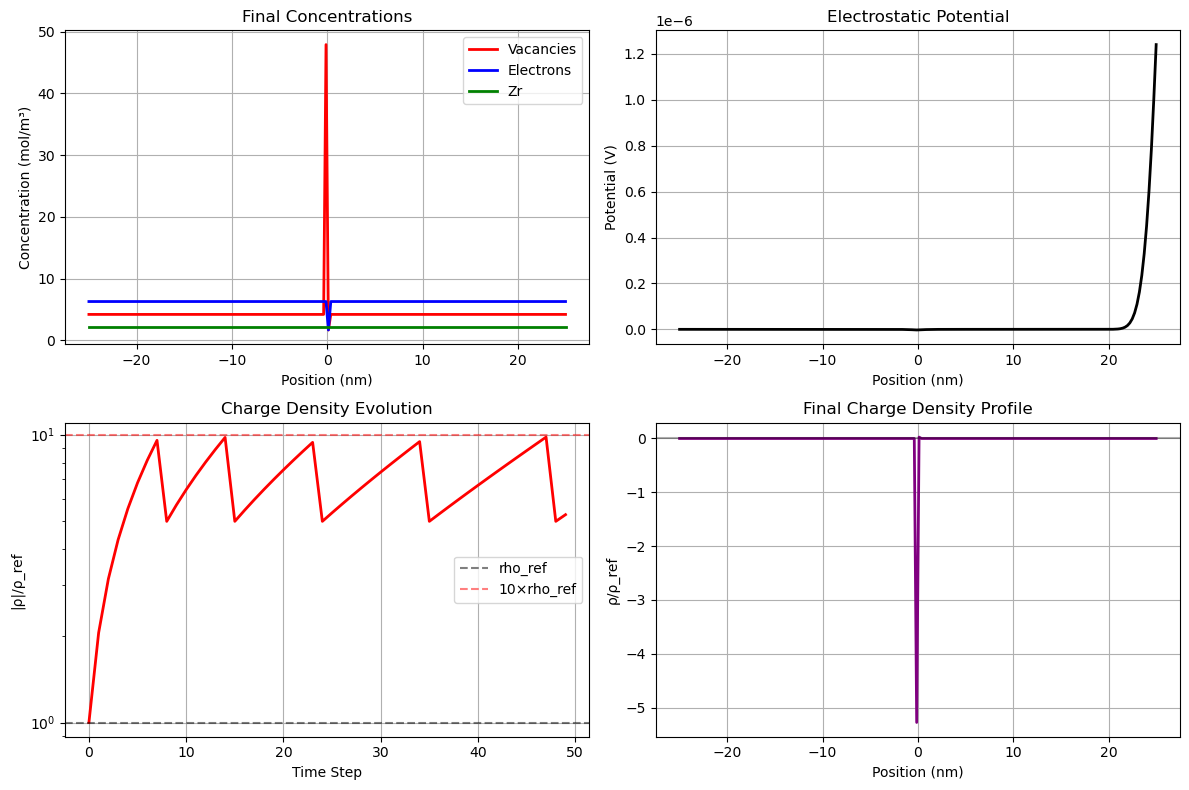

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# ========================================
# PHYSICAL CONSTANTS AND PARAMETERS
# ========================================

# Physical constants
e = 1.602e-19  # Elementary charge (C)
NA = 6.022e23  # Avogadro's number (1/mol)
kB = 1.381e-23  # Boltzmann constant (J/K)
k = kB  # Alias
T = 1273  # Temperature (K)
epsilon_0 = 8.854e-12  # Vacuum permittivity (F/m)
epsilon_r = 40.0  # Relative permittivity for YSZ
epsilon = epsilon_0 * epsilon_r  # Total permittivity

# System parameters (you'll need to set these to your values)
nx = 200  # Number of grid points
L = 50e-9  # Domain size (50 nm)
dx = L / (nx - 1)  # Grid spacing
dt = 1e-6  # Time step (you may need to adjust)

# Applied current and conductivity
i_a = 1000  # Applied current density (A/m²)
sigma = 1.0  # Conductivity (S/m)

# Reference concentrations
c_ref = 1660  # mol/m³
rho_ref = 1.6e6  # C/m³

# Species charges
charges = {
    "vac": 2,    # V_O^{2+}
    "elec": -1,  # e^-
    "yzr": -1     # Y stabilized Zr^{4+}
}

# Diffusivities (you'll need to set these to your values)
diffusivities = {
    "vac": 1e-8,   # m²/s
    "elec": 2e-4,  # m²/s (electrons much faster)
    "yzr": 5e-20    # m²/s (Zr very slow)
}

# Chemical potentials (you'll need to set these)
chemical_potentials = {
    "vac": {"mu_YSZ": 0.12, "mu_anode": 0.2},
    "elec": {"mu_YSZ": 0.0, "mu_anode": 0.0},
    "yzr": {"mu_YSZ": 0.0, "mu_anode": 0.1}
}

# Rate constants
rate_constants = {
    "vac": abs(i_a / e * NA * charges["vac"]),
    "elec": abs(i_a / e * NA * charges["vac"]),
    "yzr": 0
}

# ========================================
# ORIGINAL FUNCTIONS FROM YOUR CODE
# ========================================

def interpolator(C):
    # Interpolation function for the chemical potential, polynomial
    h = C**3 * ( 6 * C**2 - 15 * C + 10)
    return h
    
# function to calculate the chemical potential, mu
def chemical_potential(C, mu_YSZ, mu_anode):
    mu = mu_YSZ + (mu_anode - mu_YSZ) * interpolator(C)
    return mu

def interface_locator(C):
    # ensures interface reaction only occurs at interface
    lambda_C = C ** 2 * (1 - C) ** 2
    return lambda_C

def laplacian_chem(f, deltax, mu_YSZ, mu_anode):
    f[0] = mu_YSZ
    f[-1] = mu_anode
    lap = np.zeros_like(f)
    for i in range(1, len(f)-1):
        lap[i] = (f[i-1] - 2*f[i] + f[i+1]) / (deltax ** 2)
    return lap

def laplacian_conc(f, deltax, left, right):
    lap = np.zeros_like(f)

    for i in range(1, len(f)-1):

        lap[i] = (f[i-1] - 2*f[i] + f[i+1]) / (deltax ** 2)
    
    # use ghost point to enforce boundary conditions on the left and right sides (again, neumann)
    lap[0] = (f[1] - 2*f[0] + (f[1] - 2 * deltax * left)) / (deltax ** 2)
    lap[-1] = (f[-2] - 2*f[-1] + (f[-2] + 2 * deltax * right)) / (deltax ** 2)
    return lap

def laplacian_elec(f, deltax):
    # Dirichlet boundary condition for the electric potential for electrolyte
    lap = np.zeros_like(f)
    f[0] = 0.0
    for i in range(1, len(f)-1):
        lap[i] = (f[i-1] - 2*f[i] + f[i+1]) / (deltax ** 2)
    lap[-1] = (f[-2] - 2*f[-1] + (f[-2] + 2 * deltax * i_a / sigma)) / (deltax ** 2)

    return lap

def gauss_seidel_1D(varphi_s, rho, i_a, sigma, maxiter=1000, tol=1e-6):
    """Your original Poisson solver"""
    varphi = varphi_s.copy()
    N = len(varphi)
    
    for it in range(maxiter):
        varphi_old = varphi.copy()
        
        # Boundary conditions
        varphi[0] = varphi[1]  # Neumann left
        varphi[-1] = varphi[-2] + dx * i_a/sigma  # Your right BC
        
        # Interior points
        for j in range(1, N-1):
            varphi[j] = 0.5 * (varphi[j+1] + varphi[j-1] + rho[j] * dx**2 / epsilon)
        
        if np.max(np.abs(varphi - varphi_old)) < tol:
            return varphi
    
    print("Poisson solver did not converge")
    return varphi

# ========================================
# BOUNDARY CONDITIONS (YOUR CORRECTED ONES)
# ========================================

def get_boundary_conditions():
    """Get corrected boundary conditions"""
    conc_boundaries = {
        "vac": {
            "YSZ": (i_a / (e * NA * charges["vac"])) / diffusivities["vac"], 
            "anode": 0.0
        },
        "elec": {
            "YSZ": 0.0, 
            "anode": (i_a / (e * NA * charges["elec"])) / diffusivities["elec"]  # Fixed diffusivity
        },
        "yzr": {
            "YSZ": 0.0, 
            "anode": 0.0
        },
    }
    return conc_boundaries

# ========================================
# STABILITY-ENHANCED DIFFUSION FUNCTION
# ========================================

def diffusion_stable(varphi, comp, c, mu, D, z, R, left_bc, right_bc, mu_YSZ, mu_anode):
    """
    Your diffusion function with stability enhancements
    """
    
    # Chemical potential term
    chem_term = (D * c / (k * T)) * laplacian_chem(mu, dx, mu_YSZ, mu_anode)
    
    # Concentration gradient term
    conc_term = D * laplacian_conc(c, dx, left_bc, right_bc)
    
    # Electrostatic potential term
    elec_term = (D * z * e / (kB * T)) * laplacian_elec(varphi, dx)
    
    # Reaction term
    integral = np.trapz(interface_locator(comp), dx=dx) 
    K = 1.0 / integral if integral > 0 else 0.0
    sink_term = R * K * interface_locator(comp)
    
    # Calculate dc/dt
    dc_dt = chem_term + conc_term + elec_term + sink_term
    
    return dc_dt

# ========================================
# STABILITY FUNCTIONS
# ========================================

def enforce_electroneutrality(c_vac, c_elec, c_yzr, comp, charges, strength=0.5):
    """
    Enforce electroneutrality in mixed conductor regions
    """
    c_elec_new = c_elec.copy()
    
    for i in range(len(comp)):
        # Stronger enforcement in anode regions
        neutrality_strength = strength * comp[i]
        
        if neutrality_strength > 0.1:
            # Calculate target electron concentration for neutrality
            fixed_charge = charges["vac"] * c_vac[i] + charges["yzr"] * c_yzr[i]
            c_elec_target = -fixed_charge / charges["elec"]
            
            # Blend toward neutrality
            c_elec_new[i] = (1 - neutrality_strength) * c_elec[i] + neutrality_strength * c_elec_target
    
    return np.maximum(c_elec_new, 0.001 * c_ref)

def apply_charge_limiter(c_vac, c_elec, c_yzr, charges, rho_ref):
    """
    Emergency brake if charge density gets too large
    """
    rho = -e * NA * (charges["vac"] * c_vac + charges["elec"] * c_elec + charges["yzr"] * c_yzr)
    max_rho = np.max(np.abs(rho))
    
    if max_rho > 10 * rho_ref:
        print(f"Applying charge limiter: |rho| = {max_rho:.2e}")
        reduction_factor = (5 * rho_ref) / max_rho
        
        c_vac *= reduction_factor
        c_elec *= reduction_factor
        c_yzr *= reduction_factor
        
        print(f"Concentrations reduced by {reduction_factor:.3f}")
    
    return c_vac, c_elec, c_yzr

def adaptive_time_step(c_old, dc_dt, dt_current, max_change=0.05):
    """
    Adaptive time stepping to prevent large changes
    """
    if np.max(np.abs(c_old)) > 0:
        max_rel_change = np.max(np.abs(dc_dt * dt_current / (c_old + 1e-6)))
        
        if max_rel_change > max_change:
            dt_new = dt_current * max_change / max_rel_change
            return min(dt_new, dt_current)
    
    return dt_current

# ========================================
# COMPLETE SIMULATION FUNCTION
# ========================================

def run_complete_stable_simulation(nsteps=100):
    """
    Complete simulation with all your original physics plus stability
    """
    
    print("COMPLETE STABLE ELECTROCHEMICAL SIMULATION")
    print("="*60)
    
    # ========================================
    # INITIALIZATION
    # ========================================
    
    # Create domain
    x = np.linspace(-L/2, L/2, nx)
    
    # Initialize phase field (0 = YSZ, 1 = anode)
    # Simple step function for interface
    comp = np.where(x > 0, 1.0, 0.0)  # Anode on right, YSZ on left
    
    # Initialize electroneutral concentrations
    c_vac = np.full(nx, c_ref * 0.1)  # 10% of reference
    c_yzr = np.full(nx, c_ref * 0.05)  # 5% of reference
    
    # Calculate electron concentration for exact electroneutrality
    c_elec = -(charges["vac"] * c_vac + charges["yzr"] * c_yzr) / charges["elec"]
    c_elec = np.maximum(c_elec, 0.001 * c_ref)  # Ensure positive
    
    # Initialize potential
    varphi = np.zeros(nx)
    
    # Get boundary conditions
    conc_boundaries = get_boundary_conditions()
    
    # Verify initial electroneutrality
    rho_initial = -e * NA * (charges["vac"] * c_vac + charges["elec"] * c_elec + charges["yzr"] * c_yzr)
    print(f"Initial max |rho|: {np.max(np.abs(rho_initial)):.2e} C/m³")
    print(f"Initial electroneutrality: {np.max(np.abs(rho_initial)) < 1e-10}")
    
    # ========================================
    # MAIN SIMULATION LOOP
    # ========================================
    
    charge_history = []
    dt_current = dt
    
    for step in range(nsteps):
        
        # Calculate chemical potentials
        mu_vac = chemical_potential(comp, 
                                  chemical_potentials["vac"]["mu_YSZ"], 
                                  chemical_potentials["vac"]["mu_anode"])
        mu_elec = chemical_potential(comp, 
                                   chemical_potentials["elec"]["mu_YSZ"], 
                                   chemical_potentials["elec"]["mu_anode"])
        mu_yzr = chemical_potential(comp, 
                                  chemical_potentials["yzr"]["mu_YSZ"], 
                                  chemical_potentials["yzr"]["mu_anode"])
        
        # Calculate dc/dt for each species
        dc_vac_dt = diffusion_stable(varphi, comp, c_vac, mu_vac, diffusivities["vac"], 
                                   charges["vac"], rate_constants["vac"],
                                   conc_boundaries["vac"]["YSZ"], conc_boundaries["vac"]["anode"],
                                   chemical_potentials["vac"]["mu_YSZ"], chemical_potentials["vac"]["mu_anode"])
        
        dc_elec_dt = diffusion_stable(varphi, comp, c_elec, mu_elec, diffusivities["elec"], 
                                    charges["elec"], rate_constants["elec"],
                                    conc_boundaries["elec"]["YSZ"], conc_boundaries["elec"]["anode"],
                                    chemical_potentials["elec"]["mu_YSZ"], chemical_potentials["elec"]["mu_anode"])
        
        dc_yzr_dt = diffusion_stable(varphi, comp, c_yzr, mu_yzr, diffusivities["yzr"], 
                                   charges["yzr"], rate_constants["yzr"],
                                   conc_boundaries["yzr"]["YSZ"], conc_boundaries["yzr"]["anode"],
                                   chemical_potentials["yzr"]["mu_YSZ"], chemical_potentials["yzr"]["mu_anode"])
        
        # Adaptive time stepping
        dt_vac = adaptive_time_step(c_vac, dc_vac_dt, dt_current)
        dt_elec = adaptive_time_step(c_elec, dc_elec_dt, dt_current)
        dt_yzr = adaptive_time_step(c_yzr, dc_yzr_dt, dt_current)
        dt_safe = min(dt_vac, dt_elec, dt_yzr)
        
        # Update concentrations
        c_vac_new = c_vac + dc_vac_dt * dt_safe
        c_elec_new = c_elec + dc_elec_dt * dt_safe
        c_yzr_new = c_yzr + dc_yzr_dt * dt_safe
        
        # Apply stability constraints
        c_elec_new = enforce_electroneutrality(c_vac_new, c_elec_new, c_yzr_new, comp, charges, strength=0.3)
        c_vac_new, c_elec_new, c_yzr_new = apply_charge_limiter(c_vac_new, c_elec_new, c_yzr_new, charges, rho_ref)
        
        # Ensure non-negative concentrations
        c_vac = np.maximum(c_vac_new, 0.001 * c_ref)
        c_elec = np.maximum(c_elec_new, 0.001 * c_ref)
        c_yzr = np.maximum(c_yzr_new, 0.001 * c_ref)
        
        # Update electrostatic potential
        rho = -e * NA * (charges["vac"] * c_vac + charges["elec"] * c_elec + charges["yzr"] * c_yzr)
        rho_normalized = rho / rho_ref
        
        # Use damped Poisson solver for stability
        varphi = gauss_seidel_1D_damped(varphi, rho_normalized, i_a, sigma, damping=0.5)
        
        # Track charge density evolution
        max_rho = np.max(np.abs(rho))
        charge_history.append(max_rho)
        
        # Progress reporting
        if step % 10 == 0:
            print(f"Step {step:3d}: Max |rho| = {max_rho:.2e} C/m³, dt = {dt_safe:.2e} s")
        
        # Check for explosion
        if max_rho > 1e12:
            print(f"Simulation unstable at step {step}")
            break
            
        # Update time step for next iteration
        dt_current = dt_safe
    
    # ========================================
    # RESULTS
    # ========================================
    
    final_rho = charge_history[-1] if charge_history else 0
    print(f"\nSimulation completed!")
    print(f"Final charge density: {final_rho:.2e} C/m³")
    print(f"Stability ratio: {final_rho/rho_ref:.1f} (should be < 10)")
    
    if final_rho < 10 * rho_ref:
        print("STABLE SIMULATION ACHIEVED!")
    else:
        print("Still some stability issues")
    
    return x, c_vac, c_elec, c_yzr, varphi, comp, charge_history

def gauss_seidel_1D_damped(varphi_s, rho, i_a, sigma, damping=0.5, maxiter=1000, tol=1e-6):
    """
    Damped Poisson solver for better stability
    """
    varphi = varphi_s.copy()
    N = len(varphi)
    
    for it in range(maxiter):
        varphi_old = varphi.copy()
        
        # Boundary conditions
        varphi[0] = varphi[1]  # Neumann left
        varphi[-1] = varphi[-2] + dx * i_a/sigma  # Your right BC
        
        # Interior points with damping
        for j in range(1, N-1):
            varphi_new = 0.5 * (varphi[j+1] + varphi[j-1] + rho[j] * dx**2 / epsilon)
            varphi[j] = damping * varphi_new + (1 - damping) * varphi[j]
        
        if np.max(np.abs(varphi - varphi_old)) < tol:
            return varphi
    
    return varphi

def plot_results(x, c_vac, c_elec, c_yzr, varphi, charge_history):
    """
    Plot simulation results
    """
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 8))
    
    # Concentrations
    ax1.plot(x*1e9, c_vac, 'r-', label='Vacancies', linewidth=2)
    ax1.plot(x*1e9, c_elec, 'b-', label='Electrons', linewidth=2)
    ax1.plot(x*1e9, c_yzr, 'g-', label='Zr', linewidth=2)
    ax1.set_xlabel('Position (nm)')
    ax1.set_ylabel('Concentration (mol/m³)')
    ax1.set_title('Final Concentrations')
    ax1.legend()
    ax1.grid(True)
    
    # Potential
    ax2.plot(x*1e9, varphi, 'k-', linewidth=2)
    ax2.set_xlabel('Position (nm)')
    ax2.set_ylabel('Potential (V)')
    ax2.set_title('Electrostatic Potential')
    ax2.grid(True)
    
    # Charge density evolution
    ax3.semilogy(range(len(charge_history)), np.array(charge_history)/rho_ref, 'r-', linewidth=2)
    ax3.axhline(y=1, color='k', linestyle='--', alpha=0.5, label='rho_ref')
    ax3.axhline(y=10, color='r', linestyle='--', alpha=0.5, label='10×rho_ref')
    ax3.set_xlabel('Time Step')
    ax3.set_ylabel('|ρ|/ρ_ref')
    ax3.set_title('Charge Density Evolution')
    ax3.legend()
    ax3.grid(True)
    
    # Current charge density profile
    rho_final = -e * NA * (charges["vac"] * c_vac + charges["elec"] * c_elec + charges["yzr"] * c_yzr)
    ax4.plot(x*1e9, rho_final/rho_ref, 'purple', linewidth=2)
    ax4.axhline(y=0, color='k', linestyle='-', alpha=0.3)
    ax4.set_xlabel('Position (nm)')
    ax4.set_ylabel('ρ/ρ_ref')
    ax4.set_title('Final Charge Density Profile')
    ax4.grid(True)
    
    plt.tight_layout()
    plt.show()

# ========================================
# RUN SIMULATION
# ========================================

if __name__ == "__main__":
    # Run the complete simulation
    results = run_complete_stable_simulation(nsteps=50)
    x, c_vac, c_elec, c_yzr, varphi, comp, charge_history = results
    
    # Plot results
    plot_results(x, c_vac, c_elec, c_yzr, varphi, charge_history)